In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score


def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print("Error loading data:", str(e))
        return None


def preprocess_data(data):
    # Convert 'Time' and 'Amount' columns to log scale
    data['log_time'] = np.log(data['Time'] + 1)  # Adding 1 to avoid log(0)
    data['log_amount'] = np.log(data['Amount'] + 1)  # Adding 1 to avoid log(0)

    # Drop the original 'Time' and 'Amount' columns
    data.drop(columns=['Time', 'Amount'], inplace=True)

    # Normalize all features except the target ('Class')
    scaler = MinMaxScaler()
    data_normalized = data.copy()
    data_normalized[data_normalized.columns] = scaler.fit_transform(data_normalized[data_normalized.columns])

    return data_normalized


def build_autoencoder(features, hidden_layer_nodes):
    autoencoder = keras.Sequential([
       keras.Input(shape = (features,)),
       keras.layers.Dense(14, activation='relu'),
       keras.layers.Dense(7, activation='relu'),
       keras.layers.Dense(14, activation='relu'),
       keras.layers.Dense(features, activation='sigmoid')])

    autoencoder.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error loss
    return autoencoder

# Function to train autoencoder
def train_autoencoder(autoencoder, X_train, epochs=100, batch_size=64):
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# Function to calculate reconstruction error
def calculate_reconstruction_error(reconstructed_data, X_test):
    mse = np.mean(np.power(X_test - reconstructed_data, 2), axis = 1)
    return mse

def classify_data_with_f1(X_test, reconstructed_data, threshold, y_true):
    if len(X_test) != len(reconstructed_data):
        raise ValueError("Lengths of X_test and reconstructed_data do not match")

    reconstruction_errors = calculate_reconstruction_error(reconstructed_data, X_test)
    print(reconstruction_errors)
    predictions = (reconstruction_errors > threshold).astype(int)

    f1 = f1_score(y_true, predictions)
    return predictions, f1




In [22]:

file_path = "creditcard.csv" 
data = load_data(file_path)


if data is not None:
    print("Data loaded successfully.")
    print("Shape of data:", data.shape)
    print("First few rows of data:")
    print(data.head())

    # Preprocess data
    data_processed = preprocess_data(data)

# Separate fraud and non-fraud data
fraud_data = data_processed[data_processed['Class'] == 1]
non_fraud_data = data_processed[data_processed['Class'] == 0]

# Split non-fraud data into train and test sets
X_train, X_test, y_train, y_test = non_fraud_data.drop('Class', axis = 1), fraud_data.drop('Class', axis = 1), non_fraud_data['Class'], fraud_data['Class']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_ = X_train_scaled[:-100]
X_test_scaled = np.concatenate((X_test_scaled , X_train_scaled[-40000:]), axis=0)
y_test = np.concatenate((y_test, y_train[-40000:]), axis=0)
X_train = X_train_scaled_
X_test = X_test_scaled



features = X_train.shape[1]
hidden_layer_nodes = [15, 10]
autoencoder = build_autoencoder(features, hidden_layer_nodes)
train_autoencoder(autoencoder, X_train, epochs=100, batch_size=128)

Data loaded successfully.
Shape of data: (284807, 31)
First few rows of data:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.00943

In [32]:

threshold = 0.01

print("Threshold for anomaly detection:", threshold)

# Test autoencoder on test data and classify with F1 score
reconstructed_test_data = autoencoder.predict(X_test)
predictions, f1a = classify_data_with_f1(X_test, reconstructed_test_data, threshold, y_test)

print("F1 Score:", f1)
print("Number of fraud predictions:", np.sum(predictions == 1))
print("Number of non-fraud predictions:", np.sum(predictions == 0))


Threshold for anomaly detection: 0.01
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
[0.00465582 0.00234209 0.00667793 ... 0.00082506 0.00348783 0.00028172]
F1 Score: 0.714987714987715
Number of fraud predictions: 322
Number of non-fraud predictions: 40170


In [37]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [38]:
def load_data(file_path):
      data = pd.read_csv(file_path)
      return data

def preprocess_data(data):
    data['log_time'] = np.log(data['Time'] + 1) 
    data['log_amount'] = np.log(data['Amount'] + 1) 

    data.drop(columns=['Time', 'Amount'], inplace=True)
    scaler = MinMaxScaler()
    data_normalized = data.copy()
    data_normalized[data_normalized.columns] = scaler.fit_transform(data_normalized[data_normalized.columns])

    return data_normalized



In [40]:
file_path = "creditcard.csv"  
datav = load_data(file_path)

data_processedv = preprocess_data(datav)
fraud_datav = data_processedv[data_processedv['Class'] == 1]
non_fraud_datav = data_processedv[data_processedv['Class'] == 0]

X_trainv, X_testv, y_trainv, y_testv = non_fraud_datav.drop('Class', axis = 1), fraud_datav.drop('Class', axis = 1), non_fraud_datav['Class'], fraud_datav['Class']

scaler = MinMaxScaler()
X_train_scaledv = scaler.fit_transform(X_trainv)
X_test_scaledv = scaler.transform(X_testv)

X_train_scaled_v = X_train_scaledv[:-100]
X_test_scaledv = np.concatenate((X_test_scaledv , X_train_scaledv[-70000:]), axis=0)
y_testv = np.concatenate((y_testv, y_trainv[-70000:]), axis=0)

In [41]:
X_trainv = torch.tensor(X_train_scaled_v, dtype=torch.float32)
X_testv = torch.tensor(X_test_scaledv, dtype=torch.float32)

In [42]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, 16),
            nn.ReLU()

        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, 30),
            nn.ReLU()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std


    def forward(self, x):
        hidden_rep = self.encoder(x)
        mean, logvar = torch.chunk(hidden_rep, 2, dim=1)
        return  self.decoder(self.reparameterize(mean, logvar)), mean, logvar

In [43]:
def loss_fn(x, x_hat, mean, logvar):
  return (torch.mean(torch.square(x_hat-x)) -0.5*torch.sum(1+logvar-mean.pow(2)-logvar.exp()) )

In [45]:
torch.manual_seed(37)
model = VAE()
criterion = nn.MSELoss()


optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100 
for epoch in range(100):
        x = X_trainv
        y_hat, mean, logvar = model(x)

        loss = loss_fn(y_hat, x, mean, logvar)

        train_loss = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.4f}")

Epoch 1/100 loss: 179105.9375
Epoch 2/100 loss: 110903.7969
Epoch 3/100 loss: 76973.4062
Epoch 4/100 loss: 53499.5156
Epoch 5/100 loss: 36062.1758
Epoch 6/100 loss: 23449.6973
Epoch 7/100 loss: 14563.7842
Epoch 8/100 loss: 8658.9297
Epoch 9/100 loss: 4934.6152
Epoch 10/100 loss: 2718.8323
Epoch 11/100 loss: 1463.5295
Epoch 12/100 loss: 784.5342
Epoch 13/100 loss: 437.0941
Epoch 14/100 loss: 268.4658
Epoch 15/100 loss: 184.3042
Epoch 16/100 loss: 135.7598
Epoch 17/100 loss: 104.2295
Epoch 18/100 loss: 82.3948
Epoch 19/100 loss: 66.8346
Epoch 20/100 loss: 55.5421
Epoch 21/100 loss: 47.1834
Epoch 22/100 loss: 40.9218
Epoch 23/100 loss: 36.1734
Epoch 24/100 loss: 32.5459
Epoch 25/100 loss: 29.7462
Epoch 26/100 loss: 27.5525
Epoch 27/100 loss: 25.8000
Epoch 28/100 loss: 24.3613
Epoch 29/100 loss: 23.1579
Epoch 30/100 loss: 22.1218
Epoch 31/100 loss: 21.2012
Epoch 32/100 loss: 20.3553
Epoch 33/100 loss: 19.5588
Epoch 34/100 loss: 18.7955
Epoch 35/100 loss: 18.0538
Epoch 36/100 loss: 17.3234


In [47]:
# Evaluation
model.eval()
with torch.no_grad():
    reconstructed,_,_ = model(X_testv)
    mse = torch.mean((X_testv - reconstructed)**2, dim=1).numpy()

# Threshold for classification
threshold = 0.01 # np.percentile(mse, 97)  # Example threshold

# Predictions
predictionsv = (mse > threshold).astype(int)

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracyv = accuracy_score(y_testv, predictionsv)
precisionv = precision_score(y_testv, predictionsv)
recallv = recall_score(y_testv, predictionsv)
f1v = f1_score(y_testv, predictionsv)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1v)

Accuracy: 0.9942704731798874
Precision: 0.9037267080745341
Recall: 0.5914634146341463
F1 Score: 0.5542570951585977


In [49]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[39969    31]
 [  201   291]]


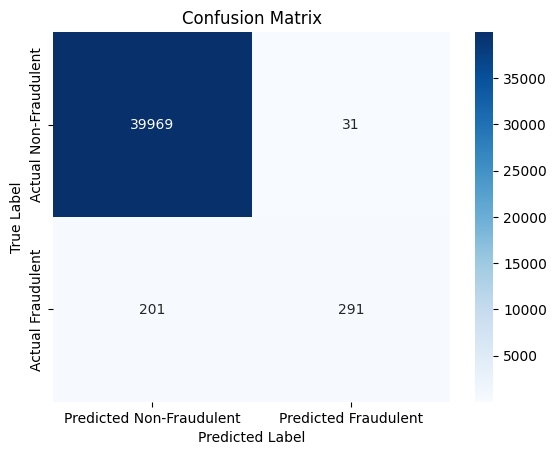

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix data
conf_matrix_data = conf_matrix

# Create a heatmap
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Non-Fraudulent', 'Predicted Fraudulent'],
            yticklabels=['Actual Non-Fraudulent', 'Actual Fraudulent'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_mat.png')
plt.show()

In [36]:
f1v

0.714987714987715

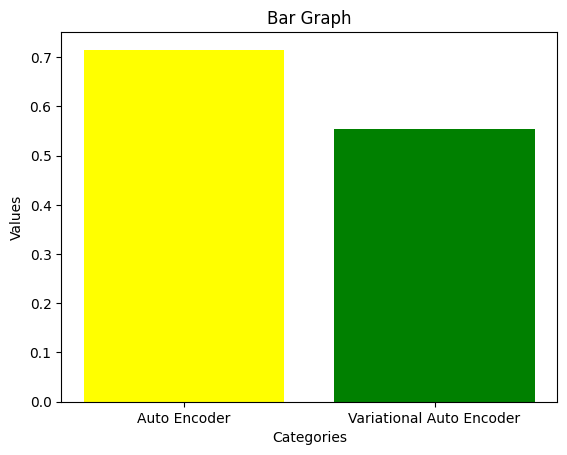

In [53]:
import matplotlib.pyplot as plt

categories = ['Auto Encoder', 'Variational Auto Encoder']
values = [f1a, f1v]
colors = ['yellow', 'green'] 
# Plotting the bar graph
plt.bar(categories, values, color=colors)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('F1 Score Graph')


plt.show()
